# Result after preprocessing and feature selection



#  XGBoost with ADASYN
Class imbalance handling:

Uses ADASYN (Adaptive Synthetic Sampling) to handle class imbalance, as mentioned in the paper


Model Training:

Implements XGBoost classifier with parameters similar to those used in the paper

Uses max_depth=4 and binary logistic objective function

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix,
                            classification_report, roc_curve)
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import ADASYN, SMOTE
from xgboost import XGBClassifier
import shap


In [ ]:
from collections import Counter

In [ ]:
def handle_class_imbalance(X_train, y_train):
    print("Class distribution before ADASYN:", Counter(y_train))

    # ADASYN
    adasyn = ADASYN(random_state=42)
    X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

    print("Class distribution after ADASYN:", Counter(y_train_adasyn))

    return X_train_adasyn, y_train_adasyn

In [ ]:
def train_xgboost(X_train, y_train):
    xgb_model = XGBClassifier(
        max_depth=4,
        objective='binary:logistic',
        n_estimators=100,
        random_state=42
    )


    xgb_model.fit(X_train, y_train)

    return xgb_model


In [ ]:
def train_xgboost(X_train, y_train, X_test=None, y_test=None):
    xgb_model = XGBClassifier(
        max_depth=4,
        objective='binary:logistic',
        n_estimators=100,
        random_state=42,
        eval_metric=['error', 'logloss']
    )

    eval_set = [(X_train, y_train)]
    if X_test is not None and y_test is not None:
        eval_set.append((X_test, y_test))

    xgb_model.fit(
        X_train,
        y_train,
        eval_set=eval_set,
        verbose=True
    )


    results = xgb_model.evals_result()
    print("\nTraining History:")
    for i, metric in enumerate(results['validation_0']):
        print(f"\nMetric: {metric}")
        for epoch, value in enumerate(results['validation_0'][metric]):
            print(f"Epoch {epoch+1}: {value:.4f}")

    plt.figure(figsize=(10, 6))
    for metric in results['validation_0']:
        plt.plot(results['validation_0'][metric], label=f'Train {metric}')

        if 'validation_1' in results:
            plt.plot(results['validation_1'][metric], label=f'Test {metric}')

    plt.title('XGBoost Training History')
    plt.xlabel('Epochs')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.grid()
    plt.show()

    return xgb_model

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"ROC AUC: {roc_auc:.2f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Diabetes', 'Diabetes'],
                yticklabels=['No Diabetes', 'Diabetes'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


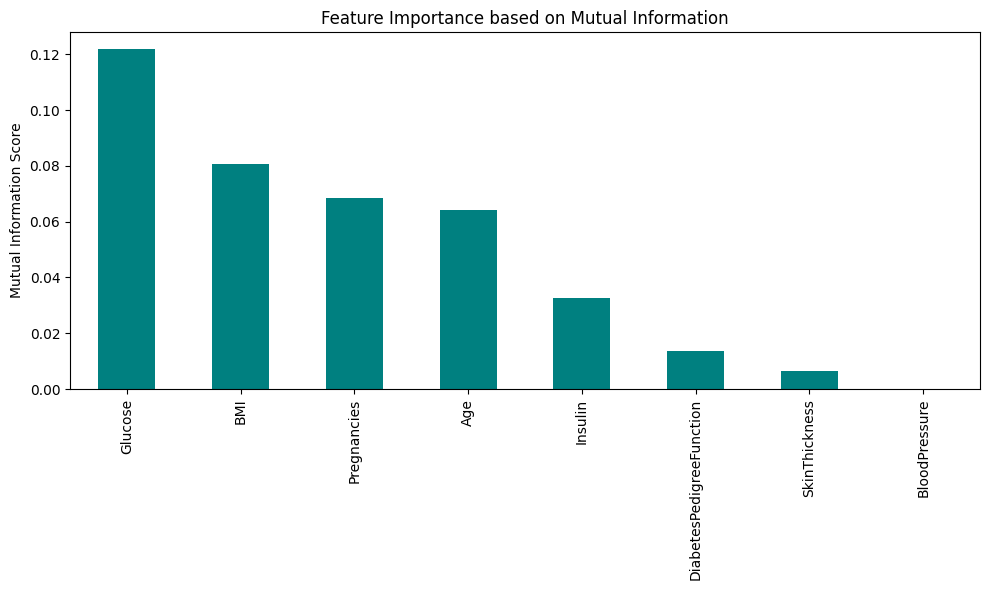

In [ ]:
data = select_features(data)
X = data.drop('Outcome', axis=1)
y = data['Outcome']
feature_names = X.columns.tolist()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=feature_names)
X_test = pd.DataFrame(scaler.transform(X_test), columns=feature_names)


In [ ]:
X_train_adasyn, y_train_adasyn = handle_class_imbalance(X_train, y_train)

Class distribution before ADASYN: Counter({0: 400, 1: 214})
Class distribution after ADASYN: Counter({0: 400, 1: 392})


[0]	validation_0-error:0.22854	validation_0-logloss:0.60215
[1]	validation_0-error:0.21212	validation_0-logloss:0.54722
[2]	validation_0-error:0.20960	validation_0-logloss:0.51082
[3]	validation_0-error:0.19444	validation_0-logloss:0.47895
[4]	validation_0-error:0.19697	validation_0-logloss:0.46010
[5]	validation_0-error:0.20455	validation_0-logloss:0.44634
[6]	validation_0-error:0.19949	validation_0-logloss:0.42933
[7]	validation_0-error:0.18939	validation_0-logloss:0.41451
[8]	validation_0-error:0.17803	validation_0-logloss:0.40433
[9]	validation_0-error:0.17929	validation_0-logloss:0.39876
[10]	validation_0-error:0.16793	validation_0-logloss:0.39010
[11]	validation_0-error:0.16414	validation_0-logloss:0.38507
[12]	validation_0-error:0.14646	validation_0-logloss:0.36713
[13]	validation_0-error:0.14141	validation_0-logloss:0.35613
[14]	validation_0-error:0.13763	validation_0-logloss:0.35013
[15]	validation_0-error:0.13889	validation_0-logloss:0.34395
[16]	validation_0-error:0.12879	va

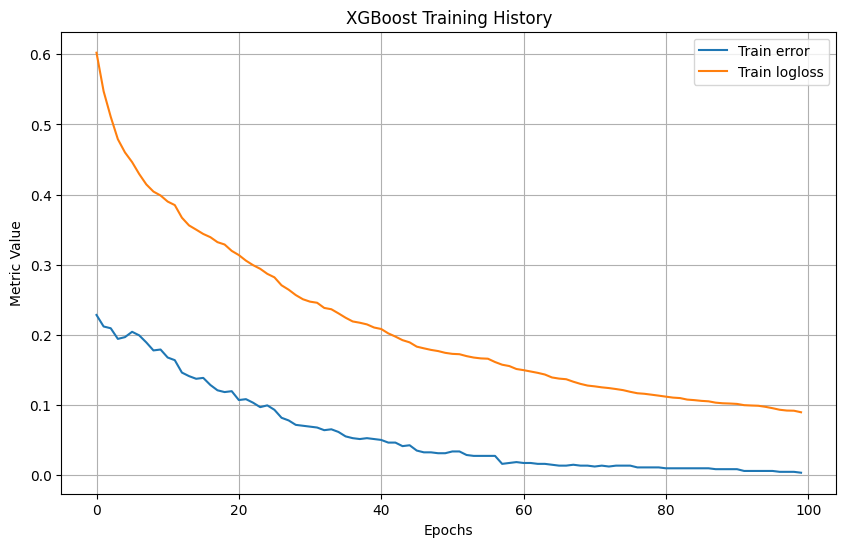

In [ ]:
xgb_model = train_xgboost(X_train_adasyn, y_train_adasyn)


Accuracy: 0.76
Precision: 0.64
Recall: 0.70
F1 Score: 0.67
ROC AUC: 0.81

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       100
           1       0.64      0.70      0.67        54

    accuracy                           0.76       154
   macro avg       0.74      0.75      0.74       154
weighted avg       0.77      0.76      0.76       154



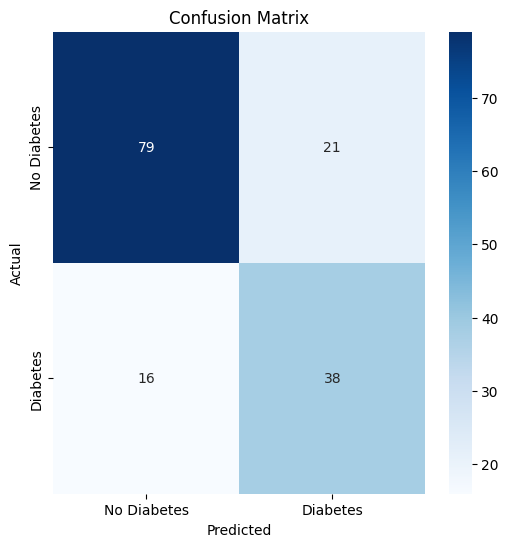

In [ ]:
metrics = evaluate_model(xgb_model, X_test, y_test)


In [ ]:
def explain_with_shap(model, X_train, X_test):
    explainer = shap.TreeExplainer(model)

    shap_values = explainer.shap_values(X_test)
    plt.figure()
    shap.summary_plot(shap_values, X_test, plot_type="bar")

    plt.figure()
    shap.summary_plot(shap_values, X_test)

    print("SHAP Force Plot for First Test Sample:")
    shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], matplotlib=True)
    plt.tight_layout()
    plt.show()


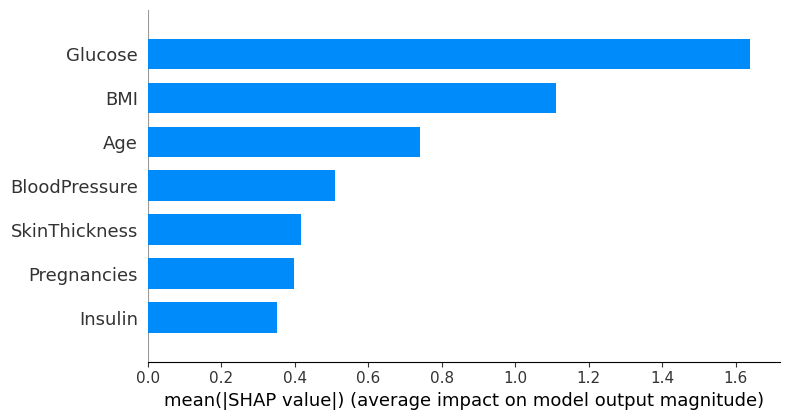

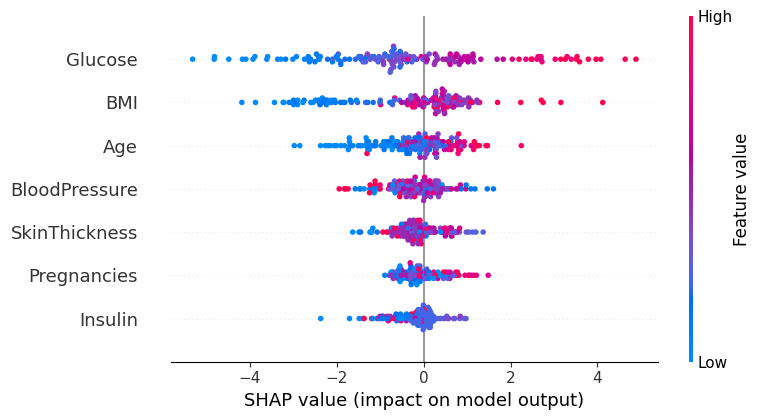

SHAP Force Plot for First Test Sample:


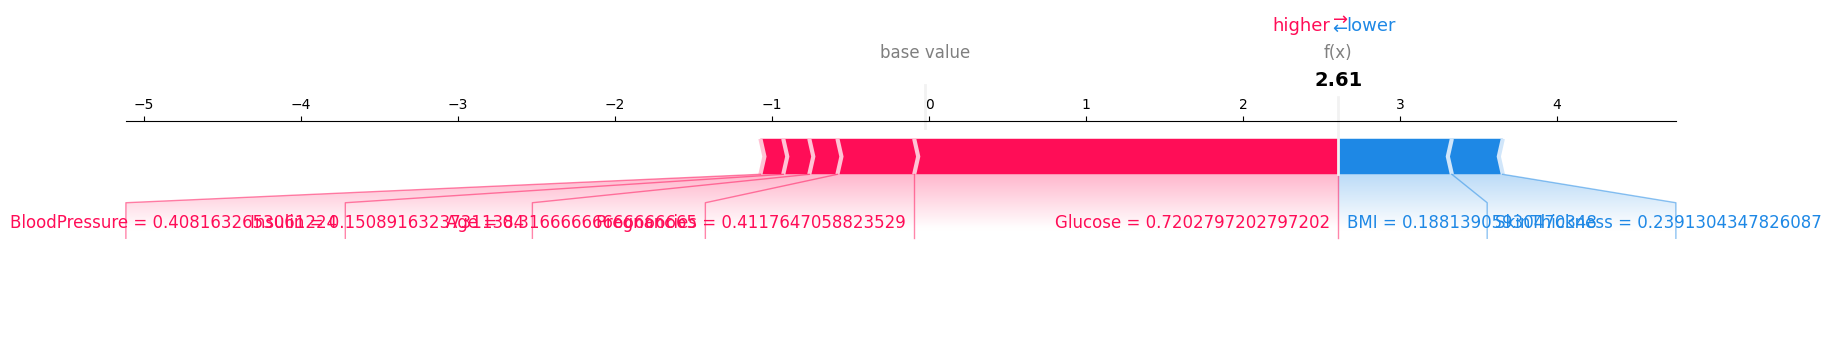

<Figure size 640x480 with 0 Axes>

In [ ]:
explain_with_shap(xgb_model, X_train_adasyn, X_test)

In [ ]:
pip install lime

In [ ]:
import lime
import lime.lime_tabular

In [ ]:
def explain_with_lime(model, X_train, X_test, feature_names):
    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_train.values,
        feature_names=feature_names,
        class_names=['No Diabetes', 'Diabetes'],
        mode='classification',
        random_state=42
    )

    exp = explainer.explain_instance(
        X_test.values[0],
        model.predict_proba,
        num_features=len(feature_names)
        )


    print("LIME  for First Test Sample:")
    exp.show_in_notebook(show_table=True)

    fig = exp.as_pyplot_figure()
    fig.suptitle('LIME', fontsize=14)
    plt.tight_layout()
    plt.show()

    return exp

LIME  for First Test Sample:


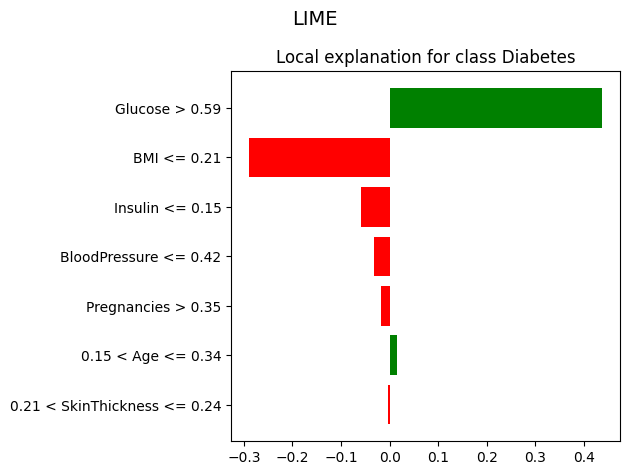

In [ ]:
explain_with_lime(xgb_model, X_train_adasyn, X_test, feature_names)


# LOFO

In [ ]:
from sklearn.model_selection import cross_val_score

def lofo_importance(model, X_train, y_train):

    baseline_score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    print(f"Baseline ROC AUC: {baseline_score:.4f}")

    lofo_scores = {}
    for col in X_train.columns:
        X_lofo = X_train.drop(columns=[col])
        score = cross_val_score(model, X_lofo, y_train, cv=5, scoring='roc_auc').mean()
        lofo_scores[col] = baseline_score - score

    lofo_df = pd.Series(lofo_scores).sort_values(ascending=True)
    plt.figure(figsize=(10, 6))
    lofo_df.plot(kind='barh', color='coral')
    plt.title("LOFO (Leave-One-Feature-Out) Importance - XGBoost")
    plt.xlabel("Decrease in ROC AUC")
    plt.tight_layout()
    plt.show()

    return lofo_df


Baseline ROC AUC: 0.8382


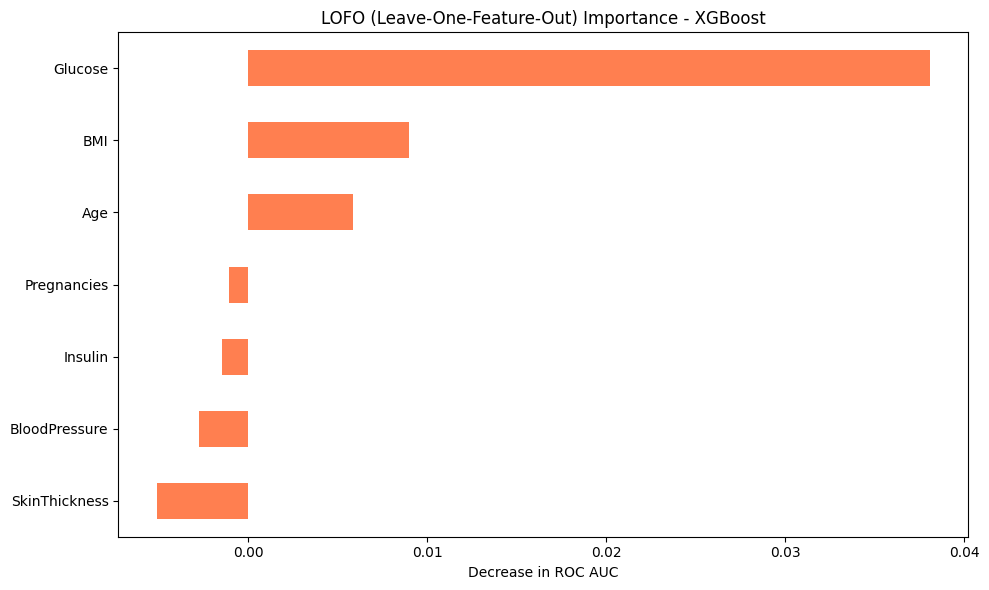

In [ ]:
lofo_importance = lofo_importance(XGBClassifier(max_depth=4, objective='binary:logistic', n_estimators=100, random_state=42),
                                          X_train_adasyn, y_train_adasyn)


# PDP

average PDP values:
 [0.37340888 0.362032   0.36018133 0.3815311  0.32777348 0.3191697
 0.3245423  0.4177567  0.44365498 0.4342679  0.394459   0.394459
 0.40922573 0.40922573 0.40922573 0.40922573]
----------------------------------------------------------
Grid values:
 [0.         0.05882353 0.11764706 0.17647059 0.23529412 0.29411765
 0.35294118 0.41176471 0.47058824 0.52941176 0.58823529 0.64705882
 0.70588235 0.76470588 0.82352941 0.88235294]


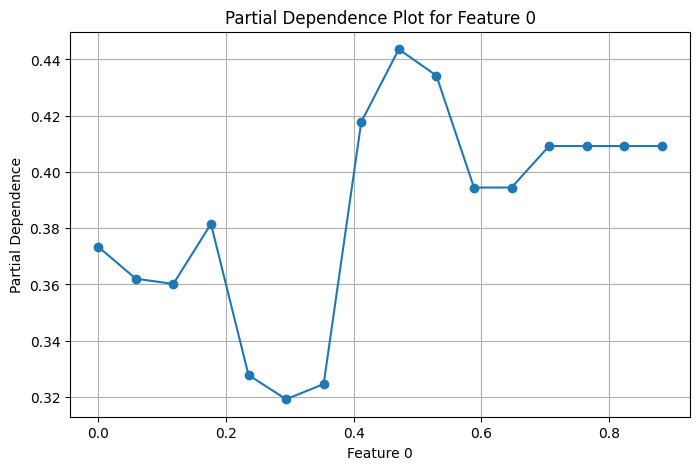

In [ ]:
from sklearn.inspection import partial_dependence
import matplotlib.pyplot as plt

feature_idx = [0]

pd_results = partial_dependence(xgb_model, X_test, features=feature_idx)

avg = pd_results.average[0]
grid = pd_results.grid_values[0]

print("average PDP values:\n", avg)
print("----------------------------------------------------------")
print("Grid values:\n", grid)

plt.figure(figsize=(8, 5))
plt.plot(grid, avg, marker='o')
plt.xlabel(f"Feature {feature_idx[0]}")
plt.ylabel("Partial Dependence")
plt.title(f"Partial Dependence Plot for Feature {feature_idx[0]}")
plt.grid(True)
plt.show()
